In [2]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(800_000_000_000)

from calitp.tables import tbl
from calitp import query_sql
import calitp.magics
import branca

import shared_utils
import utils

from siuba import *
import pandas as pd
import geopandas as gpd
import shapely

import datetime as dt
import time
from zoneinfo import ZoneInfo

import rt_analysis as rt
import importlib

import gcsfs
fs = gcsfs.GCSFileSystem()

from tqdm import tqdm_notebook
from tqdm.notebook import trange, tqdm

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
E0328 17:48:06.632730097     982 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0328 17:48:09.488014739     982 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


In [32]:
importlib.reload(utils)
importlib.reload(rt)

<module 'rt_analysis' from '/home/jovyan/data-analyses/rt_delay/rt_analysis.py'>

In [4]:
ran = fs.ls(f'{utils.GCS_FILE_PATH}rt_trips/')

In [5]:
ran_operators = [int(filename.split('rt_trips/')[1].split('_')[0])
                 for filename in ran if filename[-1] != '/']

In [6]:
ran_operators

[167, 182, 194, 243, 246, 247, 290, 294, 300, 300, 301, 315, 45, 4, 75]

In [7]:
air_joined = pd.read_parquet('airtable_joined.parquet')

In [8]:
# # ran_operators = [int(filename.split('_')[0]) for filename in os.listdir('speedmaps') if filename[0] != '.']
# ran_operators = [182, 300]

In [9]:
pbar = tqdm()

0it [00:00, ?it/s]

In [ ]:
## can add stop delay on a subsequent run, when ready for interact...

for agency in air_joined.calitp_itp_id.unique():
# for agency in [182]:
    not_ran_operators = []
    if agency in ran_operators:
        print(f'already ran: {agency}')
        continue
    analysis_date = dt.date(2022, 3, 23) ##wednesday, new tables
    day = str(analysis_date.day).zfill(2)
    month = str(analysis_date.month).zfill(2)
    print(f'calculating for agency: {agency}...')
    try:
        rt_day = rt.OperatorDayAnalysis(agency, analysis_date, pbar)
        rt_day.set_filter(start_time='15:00', end_time='19:00')
        m = rt_day.segment_speed_map(how='low_speeds', size = [1300, 700])
        shared_utils.utils.geoparquet_gcs_export(rt_day.stop_segment_speed_view,
                                                 f'{utils.GCS_FILE_PATH}segment_speed_views/',
                                                f'{agency}_{month}_{day}_pm_peak'
                                                )
        rt_day.rt_trips.to_parquet(f'{utils.GCS_FILE_PATH}rt_trips/{agency}_{month}_{day}_pm_peak.parquet') ## early step towards scaling
        # m.save(f'./speedmaps/{agency}_02_{day}_pm_peak.html')
        # rt_day.stop_segment_speed_view.to_parquet(f'{utils.GCS_FILE_PATH}segment_speed_views/{agency}_02_{day}_pm_peak.parquet') ## early step towards scaling
        delay_to_parquet = rt_day.endpoint_delay_view.copy()
        delay_to_parquet['delay_seconds'] = delay_to_parquet.delay.map(lambda x: x.seconds)
        delay_to_parquet = delay_to_parquet >> select(-_.delay)
        shared_utils.utils.geoparquet_gcs_export(delay_to_parquet,
                                         f'{utils.GCS_FILE_PATH}endpoint_delay_views/',
                                        f'{agency}_{month}_{day}_pm_peak'
                                        )
        print(f'complete for agency: {agency}')
    except Exception as e:
        print(f'rt failed for agency {agency}')
        not_ran_operators += [agency]
        print(e)

calculating for agency: 380...
found parquet
found parquet
found parquet
found parquet
rt failed for agency 380
vehicle positions trip ids not in schedule
already ran: 300
already ran: 182
already ran: 243
calculating for agency: 295...
found parquet
found parquet
found parquet
found parquet


/opt/conda/lib/python3.9/site-packages/pybigquery/sqlalchemy_bigquery.py:879: SAWarning: Did not recognize type 'GEOGRAPHY' of column 'pt_array'
/opt/conda/lib/python3.9/site-packages/siuba/sql/utils.py:52: SAWarning: Dialect bigquery:bigquery will not make use of SQL compilation caching as it does not set the 'supports_statement_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Dialect maintainers should seek to set this attribute to True after appropriate development and testing for SQLAlchemy 1.4 caching support.   Alternatively, this attribute may be set to False which will disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
/home/jovyan/data-analyses/_shared_utils/shared_utils/utils.py:38: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metad

rt failed for agency 295
'NoneType' object has no attribute 'project'
calculating for agency: 170...
found parquet
found parquet
found parquet
found parquet


/opt/conda/lib/python3.9/site-packages/pybigquery/sqlalchemy_bigquery.py:879: SAWarning: Did not recognize type 'GEOGRAPHY' of column 'pt_array'
/home/jovyan/data-analyses/_shared_utils/shared_utils/utils.py:38: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')


rt failed for agency 170
'NoneType' object has no attribute 'project'
already ran: 45
already ran: 75
already ran: 4
calculating for agency: 310...
found parquet
found parquet
found parquet
found parquet


/opt/conda/lib/python3.9/site-packages/pybigquery/sqlalchemy_bigquery.py:879: SAWarning: Did not recognize type 'GEOGRAPHY' of column 'pt_array'
/home/jovyan/data-analyses/_shared_utils/shared_utils/utils.py:38: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')


rt failed for agency 310
'NoneType' object has no attribute 'project'
calculating for agency: 314...


In [11]:
analysis_date = dt.date(2022, 3, 23) ##wednesday, new tables

In [18]:
rt_day = rt.OperatorDayAnalysis(170, analysis_date, pbar)

found parquet
found parquet
found parquet
found parquet


/opt/conda/lib/python3.9/site-packages/pybigquery/sqlalchemy_bigquery.py:879: SAWarning: Did not recognize type 'GEOGRAPHY' of column 'pt_array'
/home/jovyan/data-analyses/_shared_utils/shared_utils/utils.py:38: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')


In [70]:
rt_day.set_filter(start_time='15:00', end_time='19:00', shape_ids=['1030063'])
m = rt_day.segment_speed_map(how='low_speeds', size = [1300, 700])

view filter: {'start_time': datetime.time(15, 0), 'end_time': datetime.time(19, 0), 'route_names': ['103'], 'shape_ids': ['1030063'], 'direction_id': None, 'direction': 'Southbound'}
negative speed for shape 1030063, dropping


/home/jovyan/data-analyses/rt_delay/rt_analysis.py:605: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



In [71]:
m

### Investigate lbt odd shapes

In [52]:
lines = utils.get_routelines(170, analysis_date).dropna()

/opt/conda/lib/python3.9/site-packages/pybigquery/sqlalchemy_bigquery.py:879: SAWarning: Did not recognize type 'GEOGRAPHY' of column 'pt_array'
/home/jovyan/data-analyses/_shared_utils/shared_utils/utils.py:38: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')


In [53]:
a_shape = lines >> filter(_.shape_id == '1720090')

In [54]:
a_shape

,calitp_itp_id,calitp_url_number,calitp_extracted_at,calitp_deleted_at,shape_id,geometry
22,170,0,2021-12-14,2099-01-01,1720090,"LINESTRING (168982.728 -467847.436, 169029.505..."
46,170,0,2021-05-13,2099-01-01,1720090,"LINESTRING (167588.400 -470295.427, 167757.977..."
195,170,0,2022-02-02,2099-01-01,1720090,"LINESTRING (167579.235 -470295.935, 167595.529..."


In [56]:
lines['num_points'] = lines.geometry.apply(lambda x: len([pt for pt in x.coords]))

In [62]:
lines['has_trip'] = lines.shape_id.isin(rt_day.rt_trips.shape_id)

In [63]:
lines >> filter(_.num_points < 80) >> arrange(_.num_points)

,calitp_itp_id,calitp_url_number,calitp_extracted_at,calitp_deleted_at,shape_id,geometry,num_points,has_trip
14,170,0,2021-12-14,2099-01-01,610105,"LINESTRING (168050.092 -464617.432, 168050.092...",2,False
17,170,0,2021-12-14,2099-01-01,1740030,"LINESTRING (168982.728 -467847.436, 169029.505...",2,False
24,170,0,2021-12-14,2099-01-01,1810081,"LINESTRING (167193.543 -470028.886, 166971.226...",2,True
13,170,0,2021-12-14,2099-01-01,1510067,"LINESTRING (167073.025 -470031.290, 166971.226...",3,True
1,170,0,2021-12-14,2099-01-01,1030063,"LINESTRING (173102.310 -461425.826, 173102.310...",4,True
3,170,0,2021-12-14,2099-01-01,1910287,"LINESTRING (174799.552 -461399.277, 174799.552...",4,True
22,170,0,2021-12-14,2099-01-01,1720090,"LINESTRING (168982.728 -467847.436, 169029.505...",4,True
21,170,0,2021-12-14,2099-01-01,460063,"LINESTRING (170572.064 -468622.735, 170587.532...",5,True
28,170,0,2021-12-14,2099-01-01,460064,"LINESTRING (170572.064 -468622.735, 170587.532...",5,True
10,170,0,2021-12-14,2099-01-01,450110,"LINESTRING (170787.414 -468618.771, 170769.170...",6,False


In [49]:
len([x for x in too_straight.coords])

4

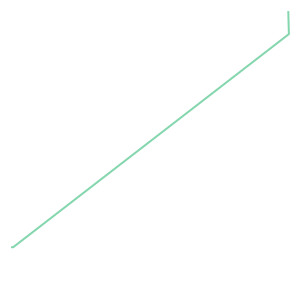

In [44]:
## this isn't correct...
too_straight = a_shape.geometry.iloc[0]
too_straight

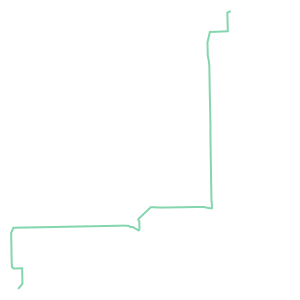

In [42]:
a_shape.geometry.iloc[1]

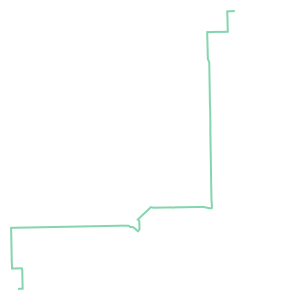

In [43]:
a_shape.geometry.iloc[2]

In [ ]:
# rt_day.rt_trips.to_parquet(f'{utils.GCS_FILE_PATH}rt_trips/{agency}_02_{day}_pm_peak.parquet') ## early step towards scaling

### another shape

In [73]:
shape2 = lines >> filter(_.shape_id == '1030063')

In [74]:
shape2

,calitp_itp_id,calitp_url_number,calitp_extracted_at,calitp_deleted_at,shape_id,geometry,num_points,has_trip
1,170,0,2021-12-14,2099-01-01,1030063,"LINESTRING (173102.310 -461425.826, 173102.310...",4,True
44,170,0,2021-05-13,2099-01-01,1030063,"LINESTRING (171924.612 -460936.065, 171923.003...",168,True
210,170,0,2022-02-02,2099-01-01,1030063,"LINESTRING (171925.408 -460990.847, 171922.908...",422,True


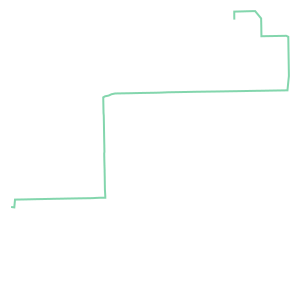

In [81]:
shape2.geometry.iloc[1]

### Ongoing issues
* 358 Union City too many trips without shape?

In [ ]:
# air_joined['url'] = air_joined.apply(lambda x:
#                     f'http://docs.calitp.org/data-analyses/rt_delay/speedmaps/{x.calitp_itp_id}_02_08_pm_peak.html',
#                                     axis = 1)

# air_joined.to_csv('linked.csv')